In [126]:
import gym
from gym import spaces

import numpy as np
import matplotlib.pyplot as plt


In [127]:
STATES = [['S' , ' ' , ' ' , ' ' , ' ' ],
          [' ' , ' ' , ' ' , ' ' , 'D' ],
          ['W' , 'W' , ' ' , 'R' , ' ' ],
          [' ' , ' ' , 'D' , ' ' , ' ' ],
          ['T' , ' ' , ' ' , ' ' , 'G' ]]

ACTIONS = {
        'L': (0,-1),
        'U': (-1,0),
        'R': (0,1),
        'D': (1,0)
    }
REWARDS = {
        'D' : -2,
        'W' : -3,
        'R' : 2,
        'G' : 4,
        'T' : 10
    }

In [133]:

class MyGridEnvironment(gym.Env):
    def __init__(self, environment:list[list]=STATES, actions:dict=ACTIONS, rewards:dict=REWARDS, p_transition:float=None, epsilon:float=None, discount_factor:float=None):
        self.environment = environment 
        self.env_row, self.env_col = len(self.environment), len(self.environment[0])
        self.states, self.start_pt, self.end_pt, self.current_pt = self._get_state_space(environment, rewards)
        self.observation_space = spaces.Discrete(self.env_row*self.env_col)
        self.action_space = spaces.Discrete(len(actions))
        self.p_transition = p_transition
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.cumulative_reward = 0
        self.observation = self.states.flatten()
        self.rewards = rewards
        self.rewards_space = self._get_reward_space(environment, rewards)
        self.max_timestep = 100
        self.timestep = 0
        self.actions, self.actions_map = self._map_actions_with_index(actions)

    def step(self, action:str=None):
        self.new_action, self.direction = self._get_action_by_p_tran(action)
        self.states[self.current_pt[0]][self.current_pt[1]] = self.rewards_space[self.current_pt[0]][self.current_pt[1]]
        self.current_pt = self._get_next_pt(self.actions_map[self.new_action])
        self.states[self.current_pt[0]][self.current_pt[1]] = -5
        self.new_reward = self.rewards_space[self.current_pt[0]][self.current_pt[1]]
        self.cumulative_reward += self.new_reward
        self.observation = self.states.flatten()
        done = True if self.timestep == self.max_timestep else False
        info = {'current_pt':self.current_pt}
        print(info)
        return self.observation, self.new_reward, done, info
        
    def reset(self):
        self.timestep = 0
        self.states, self.start_pt, self.end_pt, self.current_pt = self._get_state_space(self.environment, self.rewards)
        self.cumulative_reward = 0
        self.observation = self.states.flatten()
        return self.observation

    def render(self):
        plt.imshow(self.states)
        plt.show()

    def _get_next_pt(self, next_action):
        self.new_pt = self.current_pt + next_action
        if self.new_pt[0] < 0 or self.new_pt[0] == self.env_row or self.new_pt[1] < 0 or self.new_pt[1] == self.env_col:
            return self.current_pt
        else:
            return self.new_pt

    def _map_actions_with_index(self, actions):
        actions_list = [""]*self.action_space.n
        action_index_map_coordinate = {}
        index = 0
        for key in actions:
            actions_list[index] = key
            action_index_map_coordinate[index] = actions[key]
            index += 1
        return actions_list, action_index_map_coordinate

    def _get_state_space(self, environment:list[list]=None, rewards:dict=None):
        state_space = np.zeros((self.env_row,self.env_col))
        for r in range(self.env_row):
            for c in range(self.env_col):
                if environment[r][c] in rewards:
                    state_space[r][c] = rewards[environment[r][c]]
                
                if environment[r][c] == 'S':
                    state_space[r][c] = -5 #if states is used for rendering
                    start = np.array((r,c))
                elif environment[r][c] == 'T':
                    end = np.array((r,c))
                
                
        return state_space, start, end, start
    
    def _get_reward_space(self, environment:list[list]=None, rewards:dict=None):
        rewards_space = np.zeros((self.env_row,self.env_col))
        for r in range(self.env_row):
            for c in range(self.env_col):
                if environment[r][c] in rewards:
                    rewards_space[r][c] = rewards[environment[r][c]]                
        return rewards_space

    def _get_action_by_p_tran(self, action):
        if self.p_transition:
            actions_p_tran = np.zeros(self.action_space.n)
            actions_p_tran[self.actions.index(action)] = self.p_transition
            for i in range(self.action_space.n):
                if actions_p_tran[i] == 0:
                    actions_p_tran[i] == (1-self.p_transition)/(self.action_space.n - 1)
            final_action_index = np.random.choice(a = self.action_space.n, p = actions_p_tran)
            return final_action_index, self.actions[final_action_index]
        else:
            return self.actions.index(action), action
        

                    


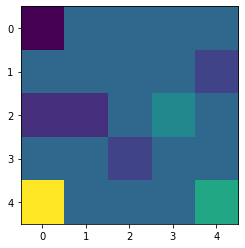

{'current_pt': array([0, 1])}
[ 0. 20.  0.  0.  0.  0.  0.  0.  0. -2. -3. -3.  0.  2.  0.  0.  0. -2.
  0.  0. 10.  0.  0.  0.  4.] {'current_pt': array([0, 1])} 0.0


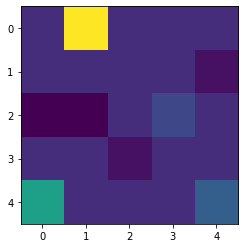

{'current_pt': array([0, 2])}
[ 0.  0. 20.  0.  0.  0.  0.  0.  0. -2. -3. -3.  0.  2.  0.  0.  0. -2.
  0.  0. 10.  0.  0.  0.  4.] {'current_pt': array([0, 2])} 0.0


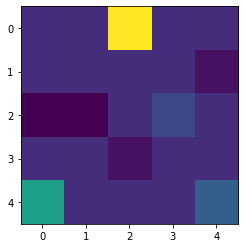

{'current_pt': array([1, 2])}
[ 0.  0.  0.  0.  0.  0.  0. 20.  0. -2. -3. -3.  0.  2.  0.  0.  0. -2.
  0.  0. 10.  0.  0.  0.  4.] {'current_pt': array([1, 2])} 0.0


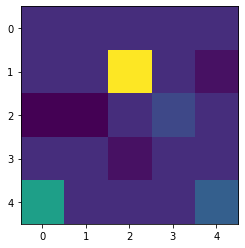

{'current_pt': array([1, 3])}
[ 0.  0.  0.  0.  0.  0.  0.  0. 20. -2. -3. -3.  0.  2.  0.  0.  0. -2.
  0.  0. 10.  0.  0.  0.  4.] {'current_pt': array([1, 3])} 0.0


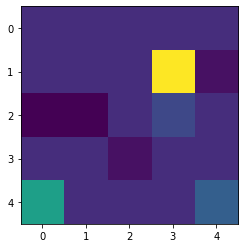

{'current_pt': array([0, 3])}
[ 0.  0.  0. 20.  0.  0.  0.  0.  0. -2. -3. -3.  0.  2.  0.  0.  0. -2.
  0.  0. 10.  0.  0.  0.  4.] {'current_pt': array([0, 3])} 0.0


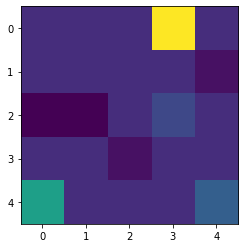

{'current_pt': array([0, 2])}
[ 0.  0. 20.  0.  0.  0.  0.  0.  0. -2. -3. -3.  0.  2.  0.  0.  0. -2.
  0.  0. 10.  0.  0.  0.  4.] {'current_pt': array([0, 2])} 0.0


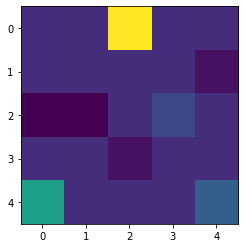

{'current_pt': array([1, 2])}
[ 0.  0.  0.  0.  0.  0.  0. 20.  0. -2. -3. -3.  0.  2.  0.  0.  0. -2.
  0.  0. 10.  0.  0.  0.  4.] {'current_pt': array([1, 2])} 0.0


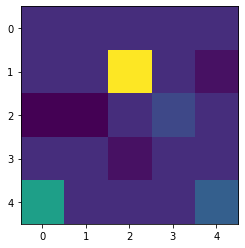

{'current_pt': array([2, 2])}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -2. -3. -3. 20.  2.  0.  0.  0. -2.
  0.  0. 10.  0.  0.  0.  4.] {'current_pt': array([2, 2])} 0.0


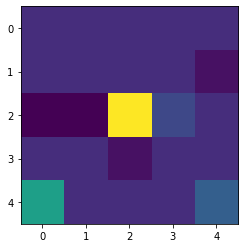

{'current_pt': array([2, 1])}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -2. -3. 20.  0.  2.  0.  0.  0. -2.
  0.  0. 10.  0.  0.  0.  4.] {'current_pt': array([2, 1])} -3.0


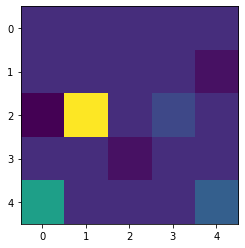

{'current_pt': array([3, 1])}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -2. -3. -3.  0.  2.  0.  0. 20. -2.
  0.  0. 10.  0.  0.  0.  4.] {'current_pt': array([3, 1])} 0.0


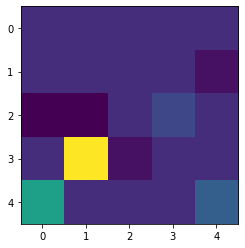

{'current_pt': array([4, 1])}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -2. -3. -3.  0.  2.  0.  0.  0. -2.
  0.  0. 10. 20.  0.  0.  4.] {'current_pt': array([4, 1])} 0.0


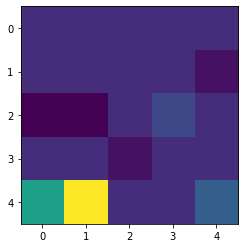

{'current_pt': array([4, 1])}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -2. -3. -3.  0.  2.  0.  0.  0. -2.
  0.  0. 10. 20.  0.  0.  4.] {'current_pt': array([4, 1])} 0.0


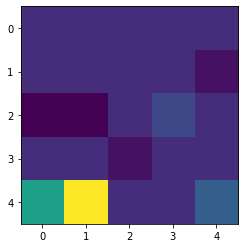

{'current_pt': array([4, 0])}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -2. -3. -3.  0.  2.  0.  0.  0. -2.
  0.  0. 20.  0.  0.  0.  4.] {'current_pt': array([4, 0])} 10.0


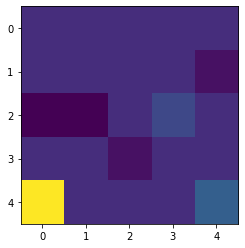

In [132]:
env = MyGridEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=1.0,epsilon=1.0,discount_factor=1)
env.render()
for action in ['R','R','D','R','U','L','D','D','L','D','D','D','L']:
    observation, reward, done, info = env.step(action)
    print(observation,info,reward)
    if done:
        env.render()
        break
    else:
        env.render()
    
#     print('----------------')
# sto.reset()
# print("The Final Reward is",reward)